# Data loading 
Next cells are used to load the data we need.

In [1]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('..')


In [2]:
#data which contains users (row), items(col) and implicit interaction (data)
dataset = pd.read_csv('data_train.csv')
dataset

,row,col,data
0,0,10080,1.0
1,0,19467,1.0
2,1,2665,1.0
3,1,7494,1.0
4,1,17068,1.0
...,...,...,...
113263,7945,2476,1.0
113264,7945,12319,1.0
113265,7945,21384,1.0
113266,7946,8699,1.0


# Data pre-processing
Pre-processing of data to check for missing users, items ecc...

In [3]:
unique_users, min_users, max_users = len(dataset.row.unique()), dataset.row.min(), dataset.row.max()
unique_items, min_items, max_items = len(dataset.col.unique()), dataset.col.min(), dataset.col.max()
print('users stats:',unique_users, min_users, max_users)
print('items stats:',unique_items, min_items, max_items)

users stats: 7947 0 7946
items stats: 24896 0 25974


If the difference between the unique elements and the max/min ones is really big, it's better to remap users and items in a new dataframe. In this case, it seems I can leave it as it is

In [4]:
users = dataset.row
items = dataset.col
data = dataset.data
URM_all = sps.coo_matrix((data, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(7947, 25975)

CSR basically has a pointer to the exact beginning of every possible row. For example if i have <code>matrix.inptr = [0,1,2,4,6] </code> this means that at <code>matrix.inptr[n]</code> I have my n row which "last" until the next cell in the array. <br> In this case (for example) my third row goes from 2 to 4. <br>

What do I do with it? <br>

I use this index (2 to 4) to access the other two arrays of the crs format: <code>indices</code> and <code>data</code>.
<code>indices</code> gives me the column index and <code>data</code> gives me the actual data to take

In [5]:
items_per_user = np.ediff1d(URM_all.indptr) #tells in which position each of the rows begin
users_per_item = np.ediff1d(sps.csc_matrix(URM_all).indptr)
URM_all = sps.csr_matrix(URM_all)

In [6]:
items_per_user = np.sort(items_per_user) #sorting based on the single value. Losing reference to the user. 
users_per_item = np.sort(users_per_item)

The following 2 graphs plots the <code>items_per_user</code> and the <code>users_per_item</code>. It shows that slightly more than 2500 users and 2500 items have a 0 count. This is coherent with the original data we got: 30910-27255 for users and 18494-15277 for items. These differences are the missing users/items in the dataset (Basically users/items that have no interaction at all)

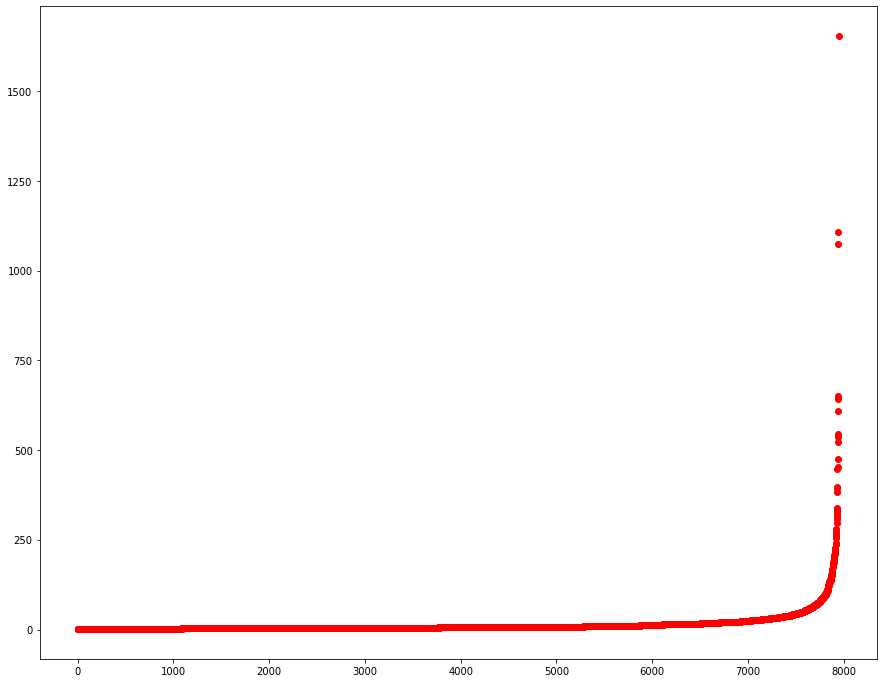

In [7]:
plt.figure(figsize=(15,12))
plt.plot(items_per_user, 'ro') #biased dataset, but not so much compared with the one seen at lessons 

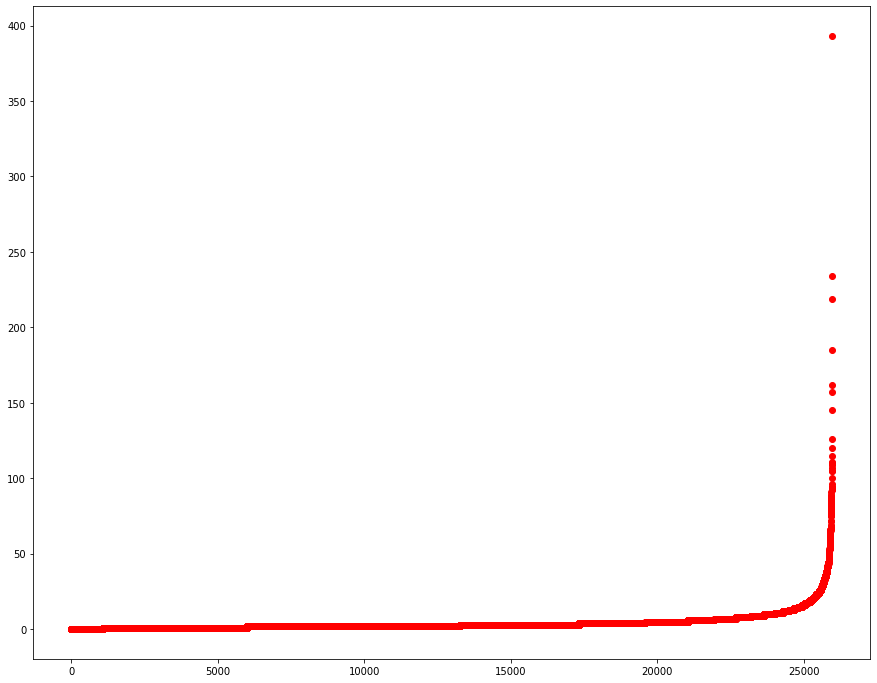

In [8]:
plt.figure(figsize=(15,12))
plt.plot(users_per_item, 'ro') #biased dataset, but not so much compared with the one seen at lessons 

In [ ]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

In [ ]:
from GraphBased.RP3betaRecommender import RP3betaRecommender

recommender = RP3betaRecommender(URM_train)

In [ ]:
x_tick = []
collaborative_MAP = []
max_map = 0
x_tick_max = ""

for topK in [70,90,100,110,120,130,150,200,250,300,350,400]:
    for alpha in [0.2,0.4,0.5,0.55,0.6,0.8,0.9]:
        for beta in [0.2,0.4,0.5,0.55,0.6,0.8,0.9]:
            x_tick.append("topk {}, alpha{}, beta{}".format(topK,alpha,beta))

            recommender = RP3betaRecommender(URM_train)

            recommender.fit(topK=topK, alpha=alpha, beta=beta, implicit=True)

            result_dict, _ = evaluator_validation.evaluateRecommender(recommender)

            collaborative_MAP.append(result_dict[10]["MAP"])

            if result_dict[10]["MAP"] > max_map:
                max_map = result_dict[10]["MAP"]
                x_tick_max = "topk {}, alpha{}, beta{}".format(topK,alpha,beta)

print("********")
print(max_map)
print(x_tick_max)

In [ ]:
import operator
index, value = max(enumerate(collaborative_MAP), key=operator.itemgetter(1))
print(index, value)
parameters = x_tick[index]
print(parameters)

In [ ]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, 1, figsize=(15, 9))
plt.plot(x_tick, collaborative_MAP, label="Collaborative")
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.001))
plt.ylabel('MAP')
plt.xlabel('TopK')
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
test_users = pd.read_csv('data_target_users_test.csv')
test_users

In [ ]:
recommender = RP3betaRecommender(URM_all)

recommender.fit(topK=70, alpha=0.4, beta=0.2, implicit=True)

user_id = test_users['user_id']
recommendations = recommender.recommend(user_id,cutoff = 10)


In [ ]:
for index in range(len(recommendations)):
    #print(element)
    recommendations[index]=np.array(recommendations[index])
    #print(type(element))
print(len(recommendations))

In [ ]:
test_users['item_list']= recommendations
#test_users['item_list'] =  test_users['item_list'].apply(lambda x: x.replace('[','').replace(']','')) 
test_users['item_list'] = pd.DataFrame([str(line).strip('[').strip(']').replace("'","") for line in test_users['item_list']])

#convert the string columns to int
#test_users['item_list'] = test_users['item_list'].astype(int)
test_users
test_users.to_csv('submission.csv', index=False)
